## Imaging Dataset: Martian Surface Features

For this imaging dataset, the method has been changed from phase 1. We have switched to clustering because the dataset is unlabeled. This was not realized during phase 1 because we assumed that the ordering of the image data would in itself lead to labels (we assumed that the data was taken in order around Mars, thus automatically leading to regions known to be suitable for landing and not). Because the data is randomly ordered, we have opted for clustering instead.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.image as mpimg


In addition to standard imports, we will also import imaging libraries to process images

### Brief Exploration of Dataset

The dataset is comprised of images taken by the Mars Reconnaissance Orbiter. The images capture the surface features of the planet and each is comprised of 277 by 277 pixels. We will further explore the dataset below.

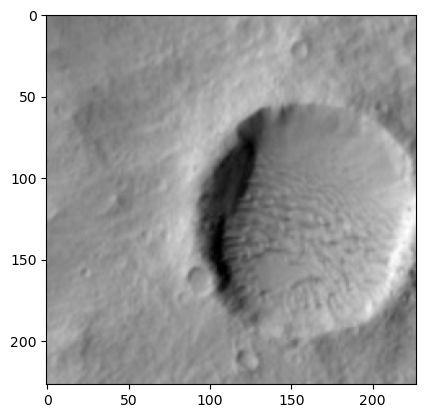

In [2]:
st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(450)
img = mpimg.imread(st)
imgplot = plt.imshow(img,cmap="gray")
plt.show()

In [3]:
print("The image size is: ", img.shape)

The image size is:  (227, 227)


Each image is as shown above comprised of greyscale images 277 by 277. However, some images are partially taken due to the mosiac process and the cuvature of Mars (NASA PDS citation). This will be taken care of during data cleaning. An example is show below:

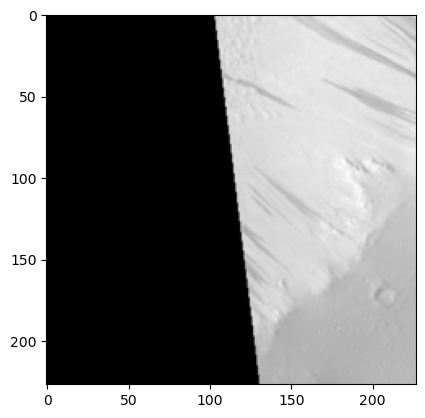

In [4]:
st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(18)
img = mpimg.imread(st)
imgplot = plt.imshow(img,cmap="gray")
plt.show()

We have set a threshold of 99% of the image being filled with color which is not deep black (RGB value = 0). The number of images which are full images by our definition are counted below:

In [5]:
count = 0
for i in range(1, 3820):
    st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(i)
    img = mpimg.imread(st)
    imgsz = len(img)**2
    zs = np.count_nonzero(img)
    if zs/imgsz >.99:
        count +=1
print("Total number of images in dataset: 3820")
print("Number of viable images: ",count)
print("Number of images with missing values: ", 3820-count)
print("Fraction of viable images: ", count/3820)

Total number of images in dataset: 3820
Number of viable images:  2672
Number of images with missing values:  1148
Fraction of viable images:  0.6994764397905759


There are a total of 3,820 images of Mars in the dataset. 1,148 of them are partial images and 2,672 of them are images we can utilize for further analysis. The fraction of "missing data" is 31%.

In [6]:
numy = []

for i in range(1, 3820):
    st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(i)
    img = mpimg.imread(st)
    imgsz = len(img)**2
    zs = np.count_nonzero(img)          
    numy.append(zs)

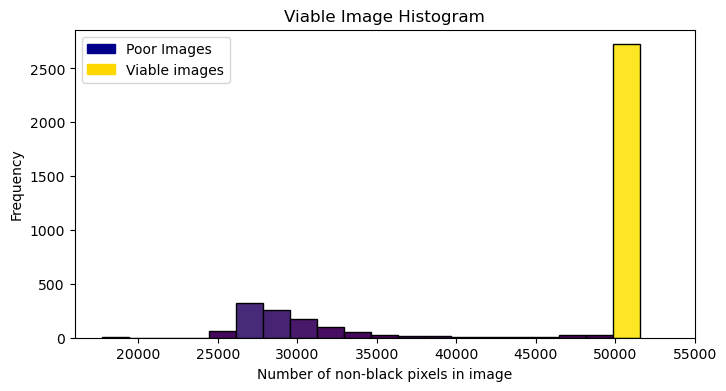

In [7]:
import matplotlib.patches as mpatches
decades = np.arange(20000, 60000, 5000)

fig, ax = plt.subplots(figsize=(8,4), facecolor='w')
cnts, values, bars = ax.hist(numy, edgecolor='k', bins=20)
ax.set_xticks(decades)

    
    
cmap = plt.cm.viridis

for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(cmap(cnt/cnts.max()))
    
plt.xlabel("Number of non-black pixels in image")
plt.ylabel("Frequency")
plt.title("Viable Image Histogram")
blue_patch = mpatches.Patch(color='darkblue', label='Poor Images')
yellow_patch = mpatches.Patch(color='gold', label='Viable images')

plt.legend(handles=[blue_patch, yellow_patch])
plt.show()

If we take a look at a sample image, we can see visualize this intensity of black/white:

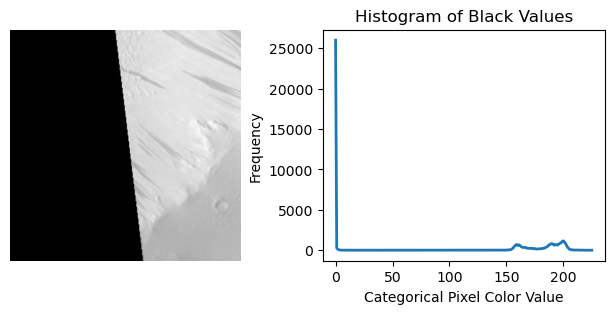

In [8]:
from skimage.exposure import histogram
st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(18)
img = mpimg.imread(st)
hist, hist_centers = histogram(img)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Black Values')
plt.xlabel("Categorical Pixel Color Value")
plt.ylabel("Frequency")

plt.show()

This image is significantly comprised of pixels from the lower end of the range.

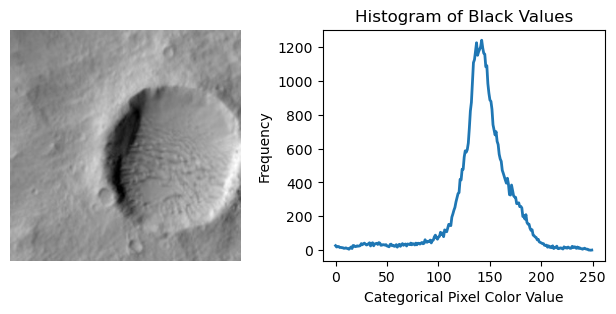

In [9]:
st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(450)
img = mpimg.imread(st)
hist, hist_centers = histogram(img)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Black Values')
plt.xlabel("Categorical Pixel Color Value")
plt.ylabel("Frequency")
plt.show()

This image is comprised of pixels from the medium end of the range.

##### Overview of dataset exploration:

In [10]:
numfeatimg = len(img)**2
numtotfeat = numfeatimg * 2672
print("Number of features per image: ", numfeatimg)
print("Number of categorical variables per feature: 256")

Number of features per image:  51529
Number of categorical variables per feature: 256


There are a total of 51,529 features per image, taking each pixel to be a feature. There are 3820 samples in the image originally. Furthermore, we can use the range of values each pixel can take to be the number of categorical values each pixel, or feature, can have. This falls under the range [0,255], giving a total of 256 categorial values for each feature.

### Preprocessing

The images with greater than 1% darkness are to be deleted. For starters, because the images are labeled with numbers [1, ..., 3820], the names of the useable images will be stored in an array:

In [11]:
# usable image names are stored in an array
useimg = []
for i in range(1, 3820):
    st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(i)
    img = mpimg.imread(st)
    imgsz = len(img)**2
    # zs counts the number of nonblack pixels in the image
    zs = np.count_nonzero(img)
    if zs/imgsz >.99:
        useimg.append(i)

Now, we can normalize each image's pixel values by, dividing by 255. This is to reduce the time for learning the dataset.

In [12]:
df1 = []
for im in useimg:
    st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(im)
    img = mpimg.imread(st)
    df1.append(img/255)

Now we will center the image pixels. This is done to further reduce complexity and computation time for feature selection. This is done by generating a mean for each pixel from all images, then subtracting this mean from each pixel.

In [13]:
dfreshaped = []
for i in df1:
    dfreshaped.append(i.reshape(1,51529))
    
mv = np.mean(dfreshaped, axis=0)
datadf = []
for element in range(len(dfreshaped)):
    datadf.append((dfreshaped[element]-mv)[0])


These standardizing steps and the reasons for them were studied from the Machine Learning Mastery website.

### Feature Extraction

We will use PCA for feature extraction.

In [14]:
# Creating a dataframe to house all the 2672 images, each with 51529 features.
g = np.array(datadf)
df = pd.DataFrame(g)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,51519,51520,51521,51522,51523,51524,51525,51526,51527,51528
0,0.100567,0.105082,0.113406,0.125326,0.137198,0.149237,0.168893,0.180194,0.195395,0.198634,...,-0.023276,-0.077677,-0.131582,-0.185891,-0.225433,-0.264989,-0.296572,-0.312679,-0.320826,-0.324957
1,0.108410,0.105082,0.097719,0.086110,0.078374,0.082570,0.098305,0.113527,0.128728,0.120202,...,0.008097,0.008598,0.005672,0.006265,-0.001904,-0.006166,-0.006375,-0.006797,-0.007101,-0.007310
2,-0.083747,-0.087074,-0.110124,-0.129576,-0.129469,-0.125273,-0.160519,-0.208041,-0.204605,-0.162151,...,0.400254,0.404676,0.405672,0.406265,0.402018,0.393834,0.385781,0.389282,0.388978,0.388768
3,0.171155,0.171749,0.176151,0.184149,0.192100,0.188453,0.184579,0.188037,0.183630,0.171183,...,0.208097,0.200754,0.209594,0.218030,0.229469,0.217364,0.193625,0.165752,0.137998,0.122101
4,0.178998,0.156063,0.121249,0.109640,0.141119,0.176688,0.176736,0.148821,0.167944,0.202555,...,0.121823,0.169382,0.205672,0.214109,0.221626,0.233050,0.228919,0.189282,0.149762,0.129945
5,0.237821,0.234494,0.223209,0.215522,0.227394,0.247276,0.255168,0.242939,0.222845,0.218241,...,0.235548,0.220362,0.189986,0.147442,0.123587,0.111481,0.111272,0.142223,0.165449,0.184846
6,0.261351,0.250181,0.211445,0.188071,0.192100,0.192374,0.192423,0.203723,0.207159,0.198634,...,0.204175,0.200754,0.209594,0.221952,0.233391,0.244815,0.252448,0.255948,0.255645,0.255435
7,0.194684,0.207043,0.234974,0.266502,0.278374,0.282570,0.294383,0.309606,0.305198,0.304516,...,0.286528,0.267421,0.268418,0.292540,0.296136,0.240893,0.174017,0.161831,0.173292,0.184846
8,0.253508,0.250181,0.238896,0.227287,0.223472,0.231590,0.243403,0.246861,0.242453,0.245692,...,0.329666,0.330166,0.315476,0.296461,0.256920,0.221285,0.209311,0.216733,0.224272,0.227984
9,0.178998,0.191357,0.215366,0.239051,0.254845,0.262962,0.239481,0.195880,0.156179,0.167261,...,0.227705,0.236048,0.229202,0.214109,0.198096,0.174227,0.154409,0.138301,0.126233,0.118180


We have created a dataframe to house all the 2672 images, each with 51529 features. Now we will perform PCA using max components and calculate how many components it takes to capture 90% of our dataset.

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaling=StandardScaler()
scaling.fit(df)
Scaled_data=scaling.transform(df)
principal=PCA(n_components=2672)
principal.fit(Scaled_data)
pcad=principal.transform(Scaled_data)

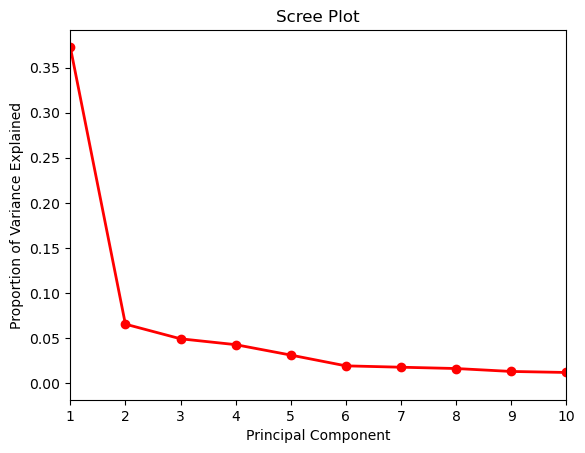

In [16]:
PC_values = np.arange(principal.n_components_) + 1
plt.plot(PC_values, principal.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xlim(1, 10)
plt.show()

We want to retain 90% of the total proportion of variance, thus, below we will determine exactly how many principal components it will take to do that.

In [17]:
i = 0
sum = 0
while sum<.9:
    sum+=principal.explained_variance_ratio_[i]
    i+=1
print("Number of principal components neeed to represent 90% of the data: ", i-1)

Number of principal components neeed to represent 90% of the data:  170


We need 170 principal components to accurately represent the data.

In [18]:
pcacompsdf = pd.DataFrame(pcad)
X = pcacompsdf.iloc[: , :170]

### Processing The Dataset

For the processing step, we have selected 2 methods of clustering:
* K-means - this was selected because of its linear time complexity, which means it will perform faster on our large dataset.
* OPTICS, a variant of DBSCAN - this was selected because it is density-based, thus is effective at dealing with outliers and noise, which is typically in large image datasets. Furthermore, unlike k-means, this will allow us to run the model without specifying the number of clusers needed.

Feature learning is complete, so now we will determine the best parameter configuration for each method of clustering.

#### K-means

In [19]:
from sklearn.cluster import KMeans

The K-means algorithm works as follows:
1. First, place random centroids for initial clusters
2. Assign each image to its nearest centroid
3. Update centroid locations based on image location in feature space
4. Repeat the previous two steps until centroid update step does not change centroid location, and images stop changing clusters.

K-means has one relavent hyperparameter: number of clusters k. In order to determine the optimal number of clusters, we will use the elbow method (cited by SciKit literature). This is done by:
1. First, compute the inertia of the points at each cluster k. Inertia is the sum of squared distances of samples to their closest cluster centroid.
2. Plot the inertia at each k value.
3. Determine where the rate of decrease in inertia begins to slow down. This point is also known as the "elbow", hence, the elbow method.
This elbow/inflection point is where the number of clusters is most optimal, because of course pursuing more clusters will yield better inertia as the number of clusters approaches the number of images, but we want to see where we can get the most images captures in the least amount of clusters. This is how we implement the elbow method. 

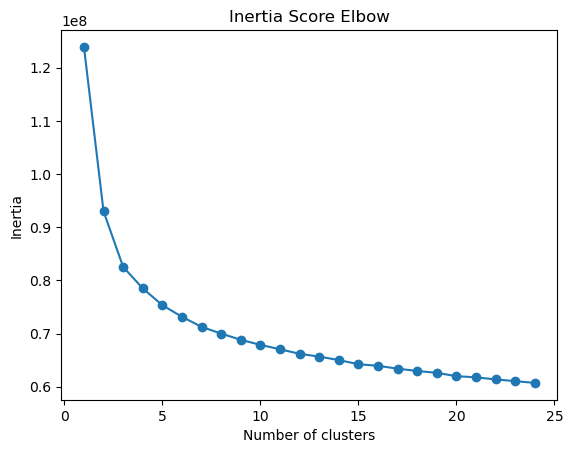

In [20]:
sse = {}
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, max_iter=3000).fit(X)
    #data["clusters"] = kmeans.labels_
    #print(kmeans.labels_)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.scatter(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Inertia Score Elbow")


plt.show()

To precisely determine the inflection point, we will see where the sign of the second derivative changes.

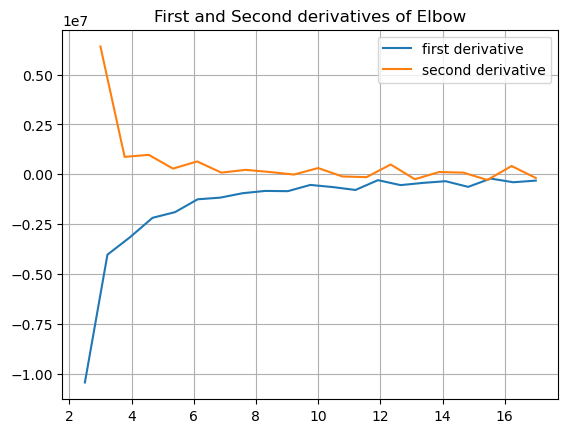

In [21]:
smooth_d1 = (np.gradient(list(sse.values())))
smooth_d2 = np.gradient(smooth_d1)


list(sse.values())

d1 = []
for element in range(2, len(list(sse.values()))-1):
    old = np.array([element-1, list(sse.values())[element-1]] )
    new = np.array([element, list(sse.values())[element]])
    d1.append(list(sse.values())[element] - list(sse.values())[element-1])

d2 = []
for element in range(1,len(d1)-1):
    d2.append(d1[element]-d1[element-1])
    
plt.plot(np.linspace(2.5, 17, 21), d1)
plt.plot(np.linspace(3, 17, 19), d2)
plt.grid()
plt.legend(["first derivative", "second derivative"])
plt.title("First and Second derivatives of Elbow")
plt.show()

From this method we can see that it takes 11 clusters for the second derivative to change signs. The first derivative tapers-off at this point as well; the change is less drastic than prior the change prior. Thus, we will tune k to be 11. This seems reasonable for a diverse set of over 2600 images.

K-means Finalzed Hyperparameter:
* k = 11

##### OPTICS

To start, we will overview DBSCAN, the precursor to OPTICS.
DBScan stands for "density-based spatial clustering of applications with noise". It functions as follows:
1. It plots the images into the n-dimensional space
2. Using a distance measurement (standard is Euclidean distance) and number of points, it determines which regions are high density and marks them as part of one cluster. 

</br>
It has two parameters:</br>
1. epsilon: specifies how close points should be to each other to be considered a part of a cluster. If the distance between two points is lower than or to equal to epsilon, these points are part of the same cluster
2. minPoints: the minimum number of points needed to form a "dense" region</br>

This formula makes it robust to outliers, which is very relavent to our dataset as the surface images are prone to noise and irregular shadows as the spacecraft orbits the object. For example, a crater will appear to have different shapes when taken from two different angles due to incident sunlight angle difference. (Cite: do Prado) </br>

However, there is an improved version of DBSCAN which, according to the scikit documentation, performs better for large datasets. It works in a fashion similar to DBSCAN, however, it does not each point to a cluster; instead, it stores the order in which the points are processed, storing the core distance and the reachabilty distance for each point. This is called OPTICS, or ordering points to identify cluster structure. </br>

<u>Core distance</u>: the minimum radius around a point to classify it as a core point</br>
<u>Core Point</u>: A point is a core point if it has more than MinPts points within eps</br>
<u>Reachability distance</u>: The maximum of the core distance and Euclidean distance between two points, undefined if the point is not a core point</br>

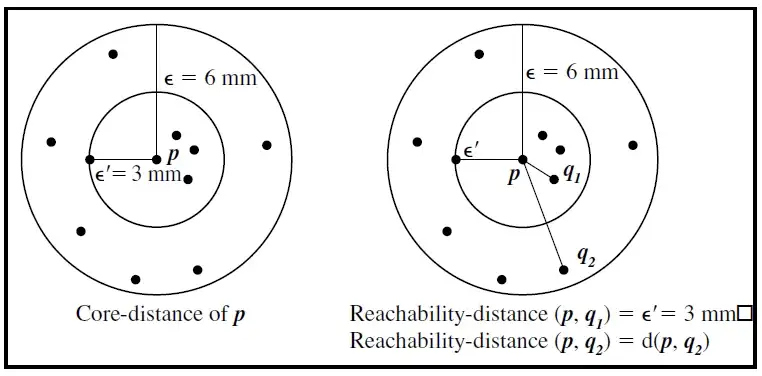




1. Retrieve the max distance neighborhood of the point, sets its reachability distance to undefined, and determines its core distance
2. Point is checked to see if it has a core distance; if not, the loop continues and the next point is retrieved from the database.
3. If it does, the point becomes a core point at a distance less than the max distance given by the max distanc neighborhood, and it gathers the points around it within the density limit and after min points is reached.
4. Objects that are directly density-reachable from a present core object are added to the OrderSeeds seed list for future growth. OrderSeeds objects are arranged by reachability-distance to the closest core object from which they have been directly density reachable. 
</br>

The process is repeated until all points have been processed. Then, a reachability plot is formed; each cluster is delineated with a sharp drop in reachability as a new core is being compared. The points that fall in between the sharp declines in reachability are considered part of the same cluster.


We have to tune one parameter with OPTICS:
* minPoints or min_samples: the minimum number of points needed to form a "dense" region

Larger minPoints => more points will be declared as noise, and clusters will be restricted to progressively more dense areas.

In [22]:
from sklearn.cluster import OPTICS
from sklearn import metrics
c = []
lstx1 = []
lsty1 = []
for i in range(3,15):
    opt = OPTICS(min_samples=i)
    clustering_labels = opt.fit_predict(X)
    s1 = metrics.davies_bouldin_score(X, clustering_labels)
    lstx1.append(i)
    lsty1.append(s1)
    c.append(clustering_labels)

We have tuned the OPTICS model using the Davies-Bouldin Index, which measures similarity between clusters as a function of intra-cluster dispersion and separation between the clusters. It was chosen because it is good at measuring average similarity of the clusters. Considering that OPTICS eliminates noise, this would be a good use case for the index because the clusters should be very different. It works as follows (Cite: pythonbloggers):

1. Calculate the average distance between each observation within the cluster and its centroid, call it A
2. Calculate the Euclidean distances between centroids, call it B
3. Calculate the similarity between two clusters: $(A1 + A2)/B12$
4. Find the most similar cluster for each cluster using the third step
5. The Davies-Bouldin Index equals the average of the similarity measures of each cluster with a cluster most similar to it

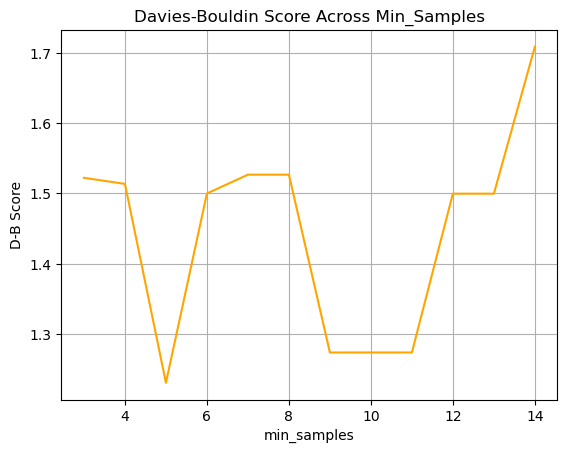

In [23]:
plt.plot(lstx1, lsty1, color = "orange")
plt.title("Davies-Bouldin Score Across Min_Samples")
plt.xlabel("min_samples")
plt.ylabel("D-B Score")
plt.grid()
plt.show()

According to the plot, the similarity score is minimized at min_samples = 5.

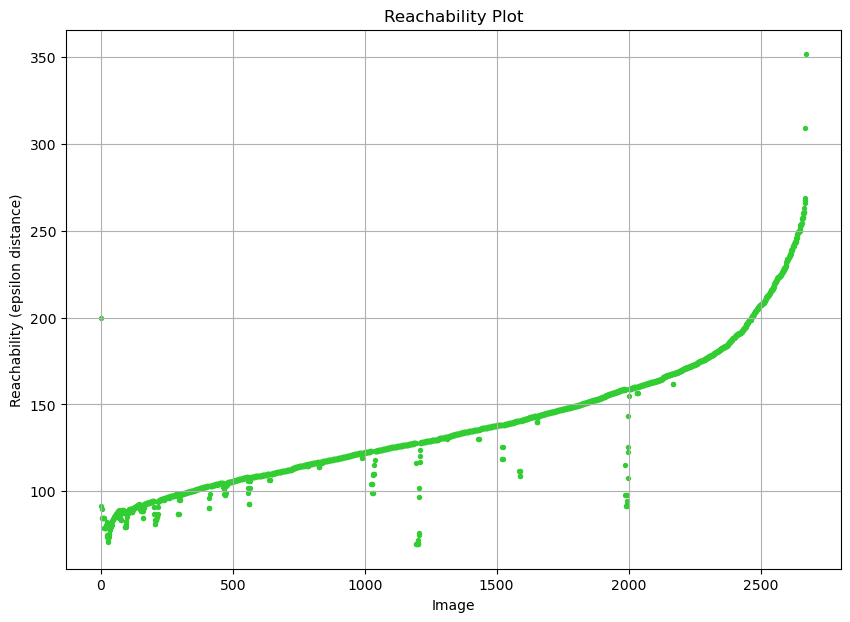

In [24]:
# Creating the Reachability Plot
opt = OPTICS(min_samples=5)
clustering_labels = opt.fit_predict(X)


plt.figure(figsize=(10, 7))

space = np.arange(len(X))
reachability = opt.reachability_[opt.ordering_]
labels = opt.labels_[opt.ordering_]

plt.title("Reachability Plot")
plt.scatter(space, reachability, s=8, color = "limegreen")
plt.ylabel("Reachability (epsilon distance)")
plt.xlabel("Image")
plt.grid()
plt.show()

This is the reachability plot created by the OPTICS model with min_samples tuned to 5. As discussed before, the sharp drops in reachability distance correspond to a new cluster. The noise is the unclustered data at the right end of the plot.

### Comparative analysis of the two methods on each dataset

First, we will compare the tuned K-means and OPTICS models using the Davies-Bouldin score:

In [25]:
Kmean = KMeans(n_clusters=11)
c= Kmean.fit_predict(X)
kdb = metrics.davies_bouldin_score(X,c)

opt = OPTICS(min_samples=5)
clustering_labels = opt.fit_predict(X)
odb = metrics.davies_bouldin_score(X, clustering_labels)


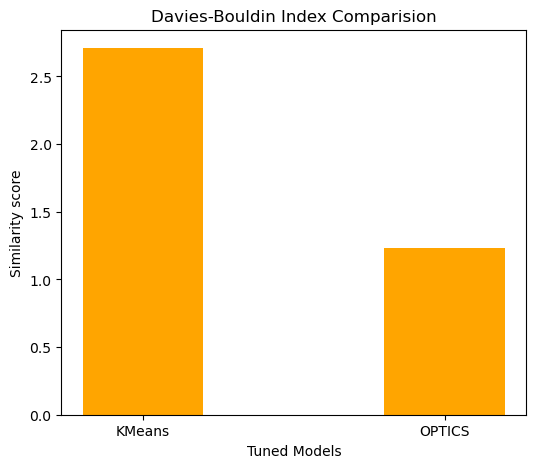

In [26]:
#kdb, odb

fig = plt.figure(figsize = (6, 5))
 
# creating the bar plot
plt.bar(['KMeans', "OPTICS"], [kdb, odb], color ='Orange',
        width = 0.4)
 
plt.xlabel("Tuned Models")
plt.ylabel("Similarity score")
plt.title("Davies-Bouldin Index Comparision")
plt.show()

In [27]:
print("K-Means: ", kdb)
print("OPTICS: ", odb)

K-Means:  2.7094846904921353
OPTICS:  1.2306026067109548


The OPTICS model definitely has a lower similarity score, thus representing the better model here. K-means returned a similarity of 2.74, while OPTICS had a score of 1.23, a difference of 1.509. This means that the clusters were very similar to one another in K-means when compared to OPTICS. This was expected, due to the noisy data input. However, while this tells us that the clusters themselves were similar to one another, it does not compare how the objects were classified. This is why we will also test using the silouhette score.

Silhouette measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
</br>

Silhouette Score = $(b-a)/max(a,b)$
</br>
a = the average distance between each point within a cluster.
</br>
b = the average distance between all clusters.



In [28]:
ksi = metrics.silhouette_score(X, c)
osi = metrics.silhouette_score(X, clustering_labels)


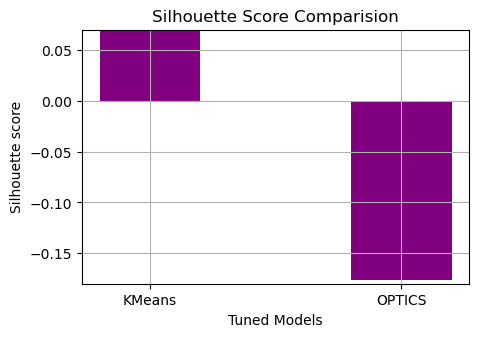

In [29]:
#osi, ksi

fig = plt.figure(figsize = (5, 3.3))
 
# creating the bar plot
plt.bar(['KMeans', "OPTICS"], [ksi, osi], color ='Purple',
        width = 0.4)
 
plt.xlabel("Tuned Models")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score Comparision")
plt.ylim(-0.18, 0.07)
plt.grid()
plt.show()

In [30]:
print("K-Means: ", ksi)
print("OPTICS: ", osi)

K-Means:  0.0702817802119621
OPTICS:  -0.17635868252443834


The range for silhouette is -1 to 1, tendency from incorrect assignment to correct assignment. This metric shows us that K-means was good at placing images into 11 different clusters. Because negative silhoutte values tend to mean that the samples have been incorrectly assigned, OPTICS was not ideal for delineating the images into distinct clusters. This is because in K-means, the ideal number of clusters was tuned using the inertia method, in other words, we tuned the model to find the closest cluster centroid, while in OPTICS, we tuned it to have intra cluster dispersion and to reduce noise based on low density areas. This means that the images within each cluster will be vert similar to one another by OPTICS, but in general a lot of the images will be relageted to noise and will not be put into clusters.

Here are a few examples of images from the same cluster formed by OPTICS:

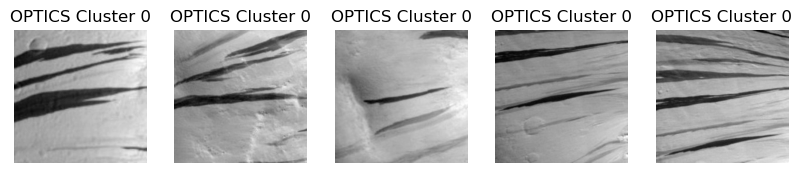

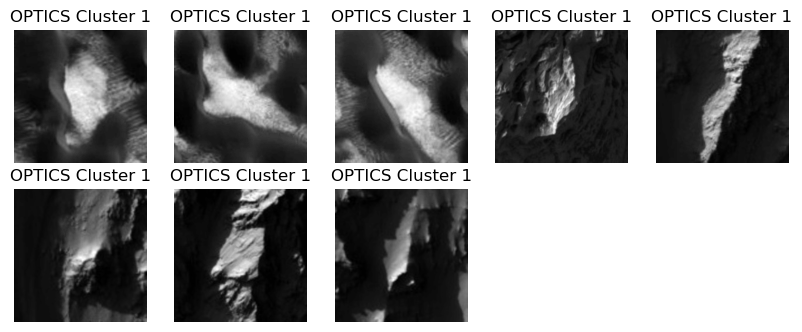

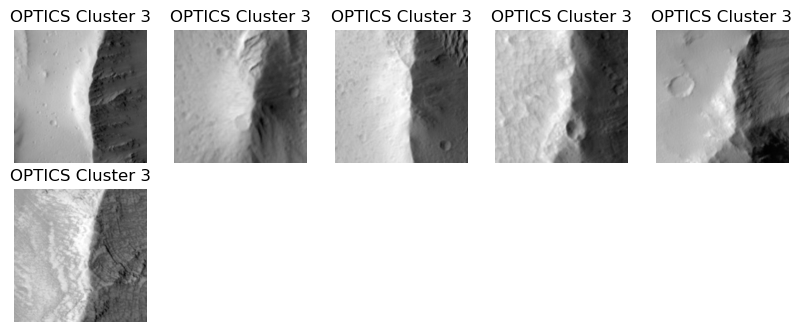

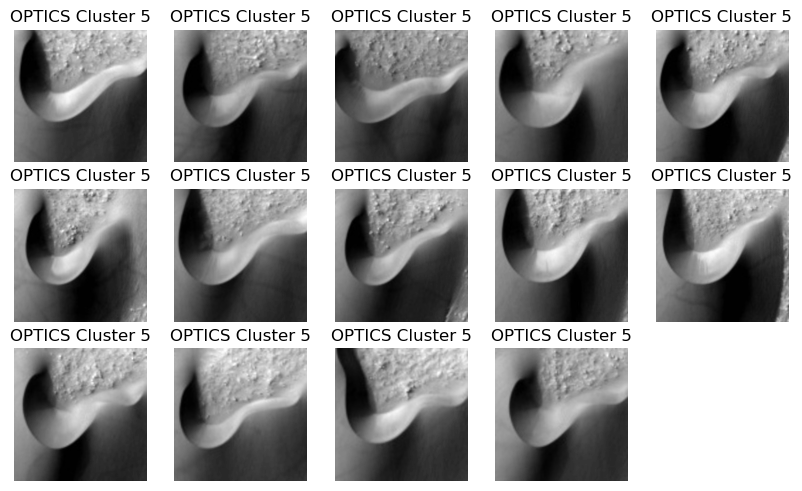

In [31]:
prt = []
for element in np.where(opt.labels_ == 0)[0]:
   prt.append(useimg[element])

im = []
for element in prt:
    st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(element)
    img = mpimg.imread(st)
    im.append(img)


plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(len(im)):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(im[i], cmap="gray")
    plt.axis('off')
    plt.title("OPTICS Cluster 0")
# plt.show()


prt = []
for element in np.where(opt.labels_ == 1)[0]:
   prt.append(useimg[element])

im = []
for element in prt:
    st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(element)
    img = mpimg.imread(st)
    im.append(img)

plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(len(im)):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(im[i], cmap="gray")
    plt.axis('off')
    plt.title("OPTICS Cluster 1")

        
prt = []
for element in np.where(opt.labels_ == 3)[0]:
   prt.append(useimg[element])

im = []
for element in prt:
    st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(element)
    img = mpimg.imread(st)
    im.append(img)

plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(len(im)):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(im[i], cmap="gray")
    plt.axis('off')
    plt.title("OPTICS Cluster 3")
    

prt = []
for element in np.where(opt.labels_ == 5)[0]:
   prt.append(useimg[element])

im = []
for element in prt:
    st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(element)
    img = mpimg.imread(st)
    im.append(img)

plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(len(im)):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(im[i], cmap="gray")
    plt.axis('off')
    plt.title("OPTICS Cluster 5")

plt.show()

It is evident that the resultant in-cluster images clearly resemble one another.

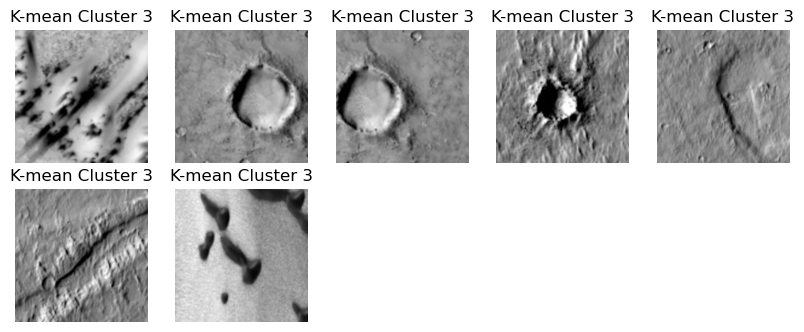

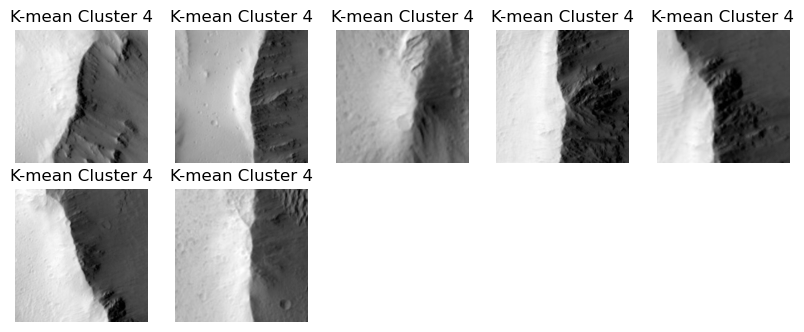

In [32]:
prt = []
for element in np.where(Kmean.labels_ == 3)[0]:
   prt.append(useimg[element])

im = []
for element in prt[0:7]:
    st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(element)
    img = mpimg.imread(st)
    im.append(img)

plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(len(im)):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(im[i], cmap="gray")
    plt.axis('off')
    plt.title("K-mean Cluster 3")
    

prt = []
for element in np.where(Kmean.labels_ == 6)[0]:
   prt.append(useimg[element])

im = []
for element in prt[0:7]:
    st = (r"C:\Users\Harish Kanagal\Documents\Machine Learning for Engineers ECE443\Final_Project\Mars\landspace ({}).jpg").format(element)
    img = mpimg.imread(st)
    im.append(img)

plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(len(im)):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(im[i], cmap="gray")
    plt.axis('off')
    plt.title("K-mean Cluster 4")

plt.show()

Here we can see that the intra cluster imagery is not as accurate as it is for OPTICS, as explained above. One applicable observation is that the K-means seems to delineate by color/brightness, while OPTICS cluster different features. 

##### Processing time and complexity:

OPTICS has a longer implementation time due to its complexity. K-means, on the other hand, has low computational complexity and rapid convergence as it finishes when the cenetroid movement is minimized. We are already providing it the total number of clusters. OPTICS also requires more memory because it is storing a min heap to idetify the next image based on reachability. But, it has the advantage in ignoring noise and also determining the number of clusters needed.

##### Overrall Recomendation:

In [33]:
print("Images per K-Means Cluster")
for lab in range(0,11):
    count = 0
    for element in np.where(Kmean.labels_ == lab)[0]:
        count+=1
    print("Cluster ", lab, ": ", count)

Images per K-Means Cluster
Cluster  0 :  216
Cluster  1 :  253
Cluster  2 :  255
Cluster  3 :  539
Cluster  4 :  328
Cluster  5 :  267
Cluster  6 :  60
Cluster  7 :  111
Cluster  8 :  412
Cluster  9 :  145
Cluster  10 :  86


In [34]:
print("Images per Optics Cluster")
for lab in range(0, 6):
    count = 0
    for element in np.where(opt.labels_ == lab)[0]:
        count+=1
    print("Cluster ", lab, ": ", count)

Images per Optics Cluster
Cluster  0 :  5
Cluster  1 :  8
Cluster  2 :  15
Cluster  3 :  6
Cluster  4 :  6
Cluster  5 :  14


Based on the outputs above, our recomendation for the better model will come based on the application it is used for. The K-Means model can be used if color/brightness is the target. It is also useful in time-intensive operations, such as fly by wire systems preparing to land on the surface. OPTICS is useful for scientific study as it is not forced to cluster all the images and can differentiate between a discrete number of images well, as evidenced by the Davies-Boudin score. As shown above, only 54 out of the 2672 images were clustered, but based on visual confirmation it is done with greater accuracy. Going by the  Silhouette score, however, K-means would be better suited for general surface image classification.

### Ethical Issues
* The major ethical issue this model possesses, even after improving with higher quality data, is safety. This model may have application on manned space exploration, by way of using clustered data to determine ideal landing locations. For an example of software safety issues in space, on Apollo 11, guidance computer threw an error and misguided the lunar module, bringing fuel levels down to dangerous levels. Human intervention and overriding the software allowed for a safe, manual descent.
* The model in its current form also has issues with accuracy, mainly due it its inability to differentiate between shadows and objects. This is why, if put into use for landing site research, the relavent results should be thoroughly reviewed by a geologist prior to application.
* An ethical good for this model is that it could lead to higher quality scientific analysis, thus leading to better exploration of outer space. The clustering may guide space adminstrations to select sample collection sites by determining unique features on the surface of Mars.

Ethical principles sourced from W3 Group

### Bibliography

* https://pds.nasa.gov/ds-view/pds/viewHostProfile.jsp?INSTRUMENT_HOST_ID=MRO
* https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/
* BARIS DINCER, NASA. Mars Surface For Machine Learning Process. Retrieved 27 November, 2022  https://www.kaggle.com/datasets/brsdincer/mars-surface-for-machine-learning-process.
* https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html
* https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80#:~:text=Based%20on%20a%20set%20of,are%20in%20low-density%20regions.
* https://analyticsindiamag.com/a-guide-to-clustering-with-optics-using-pyclustering/
* https://www.youtube.com/watch?v=GCnsmjwV3BE
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html
* https://python-bloggers.com/2021/06/davies-bouldin-index-for-k-means-clustering-evaluation-in-python/
* https://www.w3.org/TR/webmachinelearning-ethics/#accuracy